# New York taxis trips

This homework is about New York taxi trips. Here is something from [Todd Schneider](https://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/):

> The New York City Taxi & Limousine Commission has released a  detailed historical dataset covering over 1 billion individual taxi trips in the city from January 2009 through December 2019. 
Taken as a whole, the detailed trip-level data is more than just a vast list of taxi pickup and drop off coordinates: it's a story of a City. 
How bad is the rush hour traffic from Midtown to JFK? 
Where does the Bridge and Tunnel crowd hang out on Saturday nights?
What time do investment bankers get to work? How has Uber changed the landscape for taxis?
The dataset addresses all of these questions and many more.

The NY taxi trips dataset has been plowed by series of distinguished data scientists.
The dataset is available from on Amazon S3 (Amazon's cloud storage service).
The link for each file has the following form:

    https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_{year}-{month}.csv

There is one CSV file for each NY taxi service (`yellow`, `green`, `fhv`) and each calendar month (replacing `{year}` and `{month}` by the desired ones).
Each file is moderately large, a few gigabytes. 
The full dataset is relatively large if it has to be handled on a laptop (several hundred gigabytes).

You will focus on the `yellow` taxi service and a pair of months, from year 2015 and from year 2018. 
Between those two years, for hire vehicles services have taken off and carved a huge marketshare.

Whatever the framework you use, `CSV` files prove hard to handle. 
After downloading the appropriate files (this takes time, but this is routine), a first step will consist in converting the csv files into a more Spark friendly format such as `parquet`.

Saving into one of those formats require decisions about bucketing, partitioning and so on. Such decisions influence performance. It is your call.
Many people have been working on this dataset, to cite but a few:


- [1 billion trips with a vengeance](https://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/)
- [1 billion trips with R and SQL ](http://freerangestats.info/blog/2019/12/22/nyc-taxis-sql)
- [1 billion trips with redshift](https://tech.marksblogg.com/billion-nyc-taxi-rides-redshift.html)
- [nyc-taxi](https://github.com/fmaletski/nyc-taxi-map)

Depending on your internet connection, **download the files** corresponding to **"yellow" taxis** for the years 2015 and 2018. Download **at least one month** (the same) for 2015 and 2018, if you can download all of them.

**Hint.** The 12 csv for 2015 are about 23GB in total, but the corresponding parquet file, if you can create it for all 12 months, is only about 3GB.

You **might** need the following stuff in order to work with GPS coordinates and to plot things easily.

In [17]:
!pip install descartes

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [8]:
!pip install geojson geopandas plotly geopy

     |████████████████████████████████| 928 kB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 113 kB 16.5 MB/s eta 0:00:01
     |████████████████████████████████| 14.7 MB 34 kB/s s eta 0:00:01
     |████████████████████████████████| 10.9 MB 28.6 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=9530 sha256=df933140697fda7afea7c86d7acb751b9274759664f9b58b6b22a5b18ca93bea
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [9]:
!pip install ipyleaflet

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


For this homework **we will let you decide on the tools to use** (expected for Spark) and to **find out information all by yourself** (but don't hesitate to ask questions on the `slack` channel).

## Rides to the airports

In order to find the longitude and lattitude of JFK and Newark airport as well as the longitude and magnitudes 
of Manhattan, you can use a service like [geojson.io](http://geojson.io/).
Plot the following time series, indexed the day of the week and hour of the day

1. Median duration of taxi trip leaving Midtown (Southern Manhattan) headed for JFK Airport
1. Median taxi duration of trip leaving from JFK Airport to Midtown (Southern Manhattan)

## Geographic information

For this, you will need to find tools to display maps and to build choropeth maps.
We let you look and find relevant tools to do this.

1. Build a heatmap where color is a function of
    1. number of `pickups`
    2. number of `dropoffs`
    3. number of `pickups` with dropoff at some airport (JFK, LaGuardia, Newark)
2. Build a choropeth map where color is a function of
    1. number of pickups in the area
    1. ratio of number of payments by card/number of cash payments for pickups in the area
    2. ratio of total fare/trip duration for dropoff in the area
3. Build an interactive chorophet with a slider allowing the user to select an `hour of day` and where the color is a function of
    1. average number of dropoffs in the area during that hour the day
    2. average ratio of tip over total fare amount for pickups in the area at given hour of the day

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point
from ipyleaflet import Map, Heatmap
# spark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import col
import pyspark.sql.functions as fn
from pyspark.sql.catalog import Catalog
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import IntegerType, StringType
import os
import sys
from pyspark.sql import SparkSession
from pyspark import SparkConf
import ipyleaflet
import shapely
shapely.speedups.enable()

conf = SparkConf()
conf.set('spark.executor.memory', '4g')
conf.set('spark.driver.memory', '2g')
conf.set('spark.shuffle.partition', '4g')
spark = SparkSession.builder \
        .config(conf=conf) \
        .appName('web taxi') \
        .getOrCreate()


In [3]:
y15 = spark.read.parquet('yellow_tripdata_2015.parquet')
y15 = y15.drop('month')

In [25]:
y45 = y15.where('month(tpep_pickup_datetime) == 1')
y45.persist()
y45.is_cached

True

In [43]:
long_min = -74.50
long_max = -73.70
lat_min = 40.50
lat_max = 40.90
bt = y45.where(col('pickup_longitude').between(long_min, long_max) &\
          col('dropoff_longitude').between(long_min, long_max) &\
          col('pickup_latitude').between(lat_min, lat_max) &\
          col('dropoff_latitude').between(lat_min, lat_max))\
            .withColumn('pickup_longitude', fn.round('pickup_longitude', 5))\
            .withColumn('pickup_latitude', fn.round('pickup_latitude', 5))

In [5]:
#q4.3.1.A
pc = bt.limit(10**6).groupby('pickup_latitude','pickup_longitude').count()
p = pc.toPandas()
p = p.values.tolist()

In [11]:
m = Map(center=( 40.725,-74), zoom=10)
heatmap = Heatmap(
    min_opacity = 1,
    locations=p,
    radius=8,
    gradient = {0.4: 'blue', 0.6: 'cyan', 0.7: 'lime', 0.8: 'yellow', 1.0: 'red'}
)
m.add_layer(heatmap);
m

Map(center=[40.725, -74], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [12]:
#q4.3.1.B
dc = bt.limit(10**6).groupby('dropoff_latitude','dropoff_longitude').count().toPandas()
p = dc.values.tolist()

In [13]:
m = Map(center=( 40.725,-74), zoom=10)
heatmap = Heatmap(
    min_opacity = 3,
    locations=p,
    radius=8,
    gradient = {0.4: 'blue', 0.6: 'cyan', 0.7: 'lime', 0.8: 'yellow', 1.0: 'red'}
)
m.add_layer(heatmap);
m

Map(center=[40.725, -74], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [23]:
#q4.3.1.C
air = gpd.read_file("airports.geojson")

In [24]:
air

,name,geometry
0,JFK,"POLYGON ((-73.81165 40.66029, -73.81847 40.661..."
1,NL,"POLYGON ((-74.18226 40.70407, -74.18449 40.695..."


In [50]:
pbt = bt.select('pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude').limit(10**4).toPandas()

In [51]:
gdf = gpd.GeoDataFrame(pbt, geometry=gpd.points_from_xy(pbt.pickup_longitude, pbt.pickup_latitude))

In [52]:
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(pbt.dropoff_longitude, pbt.dropoff_latitude))

In [14]:
#4.3.2.A
long_min = -74.10
long_max = -73.75
lat_min = 40.55
lat_max = 40.85
bt = y45.where(col('pickup_longitude').between(long_min, long_max) &\
          col('dropoff_longitude').between(long_min, long_max) &\
          col('pickup_latitude').between(lat_min, lat_max) &\
          col('dropoff_latitude').between(lat_min, lat_max))\
            .withColumn('pickup_longitude', fn.round('pickup_longitude', 3))\
            .withColumn('pickup_latitude', fn.round('pickup_latitude', 3))

In [15]:
long_min = -74.10
long_max = -73.75
lat_min = 40.55
lat_max = 40.85
df = gpd.read_file("nyu.json")
df = df[['id','geometry']]
df = df.astype({"id": int})
df = gpd.GeoDataFrame(df, geometry=df.geometry)
df = df.cx[long_min:long_max, lat_min:lat_max]

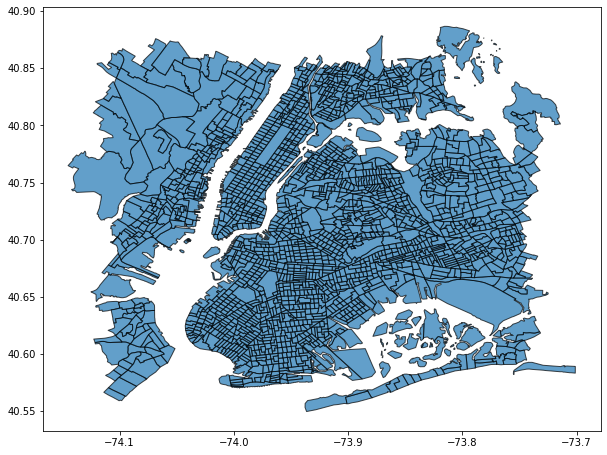

In [18]:
ax = df.plot(figsize=(10, 10), alpha=.7, edgecolor='k')

In [19]:
pc = bt.groupby('pickup_latitude','pickup_longitude').count()
p = pc.toPandas()

In [20]:
#COMPUTE APRES APPEL A LA FONCTION FR()
gdf = gpd.GeoDataFrame(p, geometry=gpd.points_from_xy(p.pickup_longitude, p.pickup_latitude))
gdf = gdf[['geometry','count']]

In [21]:
def fr(poly):
    global gdf
    re = gdf[gdf.geometry.within(poly)]
    #index to substract gdf
    gdf=  gdf.drop(re.index)
    
    #return
    return re['count'].sum()
df['count'] = df.geometry.apply(fr)

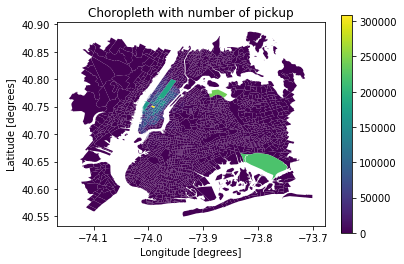

In [254]:
fig, ax = plt.subplots(1, 1)
df.plot(column='count', ax=ax, legend=True)
plt.xlabel('Longitude [degrees]')
plt.ylabel('Latitude [degrees]')
plt.title('Choropleth with number of pickup')
plt.show()